In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from textblob import TextBlob

import utils

# Ignore all warnings
warnings.filterwarnings("ignore")

# Download NLTK resources
utils.checkForNLTKResources()

trainDataset = "_data/train_essays.csv"
testDataset = "_data/test_essays.csv"
promtDataset = "_data/train_prompts.csv"

trainDf = pd.read_csv(trainDataset)
testDf = pd.read_csv(testDataset)
promptDf = pd.read_csv(promtDataset)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pauloakira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pauloakira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pauloakira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<h2>Data analysis</h2>

In [2]:
print("--------trainDf-------")
print(trainDf.info())
print("\n")

print("--------testDf-------")
print(testDf.info())
print("\n")

print("--------promptDf-------")
print(promptDf.info())

--------trainDf-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


--------testDf-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 204.0+ bytes
None


--------promptDf-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        -------------- 

Prompt Name: Car-free cities
Prompt Name: Does the electoral college work?


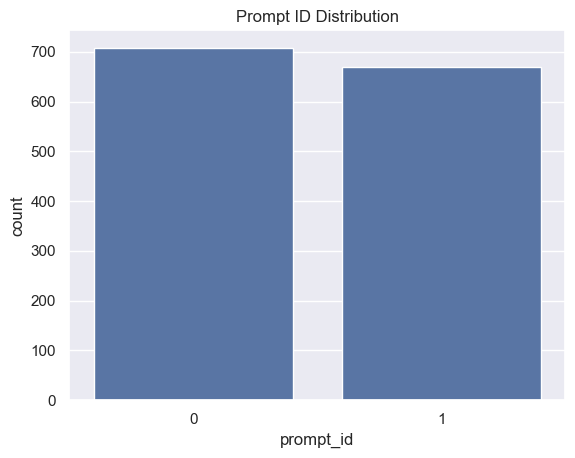

In [3]:
# prompt id distribution
promptNameList = promptDf['prompt_name'].tolist()
for promptName in promptNameList:
    print(f"Prompt Name: {promptName}")
sns.set(style="darkgrid")
sns.countplot(x='prompt_id', data=trainDf)
plt.title('Prompt ID Distribution')
plt.show()

Human: 1375
AI: 3


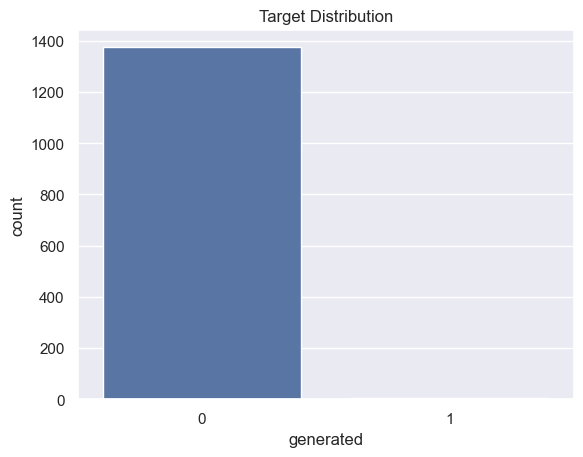

In [4]:
# target distribution
generated = trainDf['generated'].value_counts().to_dict()
print(f"Human: {generated[0]}")
print(f"AI: {generated[1]}")
sns.countplot(x='generated', data=trainDf)
plt.title('Target Distribution')
plt.show()

In [5]:
# external datasets to complete the training set
externalLLMGeneratedTextsDf = pd.read_csv("_data/LLM-Mistral-7B-Instruct-texts/Mistral7B_CME_v7.csv")
print("------LLM Mistral 7B Dataset------")
print(externalLLMGeneratedTextsDf.info())
print("\n")

print("------LLM Mistral 7B Disitrbution------")
print(externalLLMGeneratedTextsDf['prompt_name'].value_counts())
print("\n")

promptNames = promptDf['prompt_name'].to_list()
externalLLMDf = externalLLMGeneratedTextsDf[externalLLMGeneratedTextsDf['prompt_name'].isin(promptNames)]
externalLLMDf.loc[:,'generated'] = 1
promptId_map_dict = {2: 0 , 12: 1} # matching prompt_id columns with the train dataset
externalLLMDf["prompt_id"] = externalLLMDf["prompt_id"].map(promptId_map_dict)
externalLLMDf = externalLLMDf.drop(columns=['prompt_name'])
print("------External Dataset------")
print(externalLLMDf.info())
print("\n")
print("------External Dataset Distribution------")
print(externalLLMDf['prompt_id'].value_counts())

# prepare train dataset to be concatenated with the external dataset
trainDf = trainDf.drop(columns=['id'])

------LLM Mistral 7B Dataset------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prompt_id    4900 non-null   int64 
 1   text         4900 non-null   object
 2   prompt_name  4900 non-null   object
 3   generated    4900 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 153.3+ KB
None


------LLM Mistral 7B Disitrbution------
Exploring Venus                     700
The Face on Mars                    700
A Cowboy Who Rode the Waves         700
Driverless cars                     700
Facial action coding system         700
Car-free cities                     700
Does the electoral college work?    700
Name: prompt_name, dtype: int64


------External Dataset------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400 entries, 3500 to 4899
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     -------

------Concatenated Dataset------
<class 'pandas.core.series.Series'>
RangeIndex: 2778 entries, 0 to 2777
Series name: generated
Non-Null Count  Dtype
--------------  -----
2778 non-null   int64
dtypes: int64(1)
memory usage: 21.8 KB
None


------Concatenated Dataset Generated Distribution------
1    1403
0    1375
Name: generated, dtype: int64


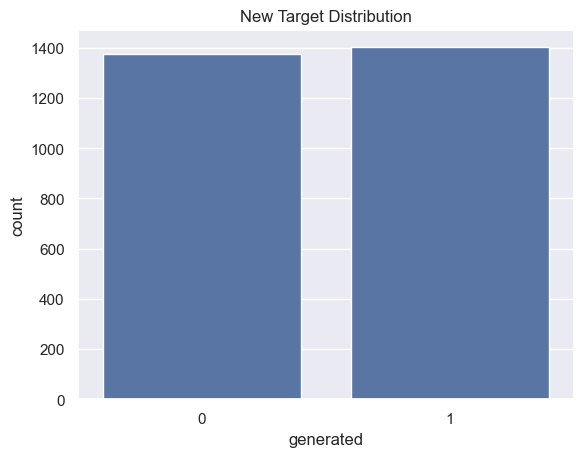

In [6]:
# concatenate the traind dataset with the external LLM dataset
newTrainDf = pd.concat([trainDf, externalLLMDf], ignore_index=True)
print("------Concatenated Dataset------")
print(newTrainDf['generated'].info())
print("\n")
print("------Concatenated Dataset Generated Distribution------")
print(newTrainDf['generated'].value_counts())
sns.countplot(x='generated', data=newTrainDf)
plt.title('New Target Distribution')
plt.show()

In [7]:
# verify if there are duplicates and drop if there is any
print(f"Before dropping duplicates: {len(newTrainDf)}")
newTrainDf = newTrainDf.drop_duplicates(subset=['text'])
print(f"After dropping duplicates: {len(newTrainDf)}")

Before dropping duplicates: 2778
After dropping duplicates: 2778


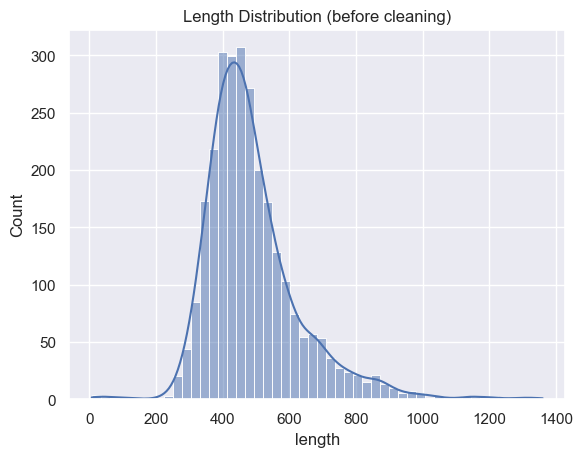

In [8]:
# check the length of the essays
newTrainDf['length'] = newTrainDf['text'].apply(lambda x: len(x.split()))
sns.histplot(newTrainDf['length'], bins=50, kde=True)
plt.title('Length Distribution (before cleaning)')
plt.show()

newTrainDf['cleaned_text'] = newTrainDf['text'].apply(lambda s: utils.cleanText(s))
newTrainDf['cleaned_length'] = newTrainDf['cleaned_text'].apply(lambda x: len(x.split()))
sns.histplot(newTrainDf['cleaned_length'], bins=50, kde=True)
plt.title('Length Distribution (after cleaning)')
plt.show()

<h2> Feature Engineering</h2>

In [ ]:
# Adding new features regarding the text information
newTrainDf = utils.computeNumericalFeatures(newTrainDf)

In [ ]:
newTrainDf[newTrainDf['generated'] == 0]['num_words'].describe()

count    1375.000000
mean      285.917091
std        87.193708
min       131.000000
25%       227.000000
50%       267.000000
75%       328.000000
max       883.000000
Name: num_words, dtype: float64

In [ ]:
newTrainDf[newTrainDf['generated'] == 1]['num_words'].describe()

count    1403.000000
mean      238.351390
std        48.856202
min         6.000000
25%       208.000000
50%       237.000000
75%       269.000000
max       461.000000
Name: num_words, dtype: float64

<h2>Naive Bayes approach</h2>

In [ ]:
# TF-IDF matrix with and without additional features
tfidf_matrix = utils.tfidfVectorizer(newTrainDf)
tfidf_matrix_with_features = utils.tfidfVectorizer(newTrainDf, True)

print("------Shape of the TF-IDF matrix------")
print(f"TF-IDF matrix: {tfidf_matrix.shape}")
print(f"TF-IDF matrix with neumerical features: {tfidf_matrix_with_features.shape}")

------Shape of the TF-IDF matrix------
TF-IDF matrix: (2778, 15667)
TF-IDF matrix with neumerical features: (2778, 15672)


In [ ]:
from ml import NaiveBayes

naiveBayes = NaiveBayes(tfidf_matrix=tfidf_matrix, df=newTrainDf)
model = naiveBayes.train_multinomial()
y_pred = naiveBayes.getTestPrediction()

# Metrics for the model
accuracy_score, classification_report = naiveBayes.getScoreMetrics()
print("\n")
score, mean, std = naiveBayes.crossValidation(model, k=5)

# Check possible model errors
error_df = naiveBayes.evaluteModelErrors()

Accuracy: 0.9982014388489209
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       284
           1       1.00      1.00      1.00       272

    accuracy                           1.00       556
   macro avg       1.00      1.00      1.00       556
weighted avg       1.00      1.00      1.00       556



Cross validation scores: [0.98741007 1.         1.         0.9981982  1.        ]
Mean score: 0.9971216540281288
Standard deviation: 0.004905678353875778
